In [ ]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from SystemIdentification import *
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
from IPython.display import Audio
import scipy.linalg as linalg

In [15]:
def CalculateOptimumFilter(input_signal, desired_response, order = None, p = None, rxy = None):
    # Checks
    if (p is None) != (rxy is None):
        raise TypeError("p and R must be specified together")

    # Calculate the parameters if not provided
    if p is None and rxy is None:
        # Calculate the autocorrelation sequence p and crosscorrelation matrix using the toeplitz property
        p = sp.correlate(input_signal, input_signal, mode = "full") / len(input_signal)
        rxy = sp.correlate(desired_response, input_signal , mode = "full") / len(input_signal)

        # Only keep the positive lag ends
        p = p[len(rxy)//2:]
        rxy = rxy[len(rxy)//2:]

        # Truncate according to the filter order. Use max range of values if the order is not specified
        if order is not None:
            p = p[:order+1]
            rxy = rxy[:order+1]

    R = linalg.toeplitz(p)
    wo = np.dot(linalg.inv(R), rxy)

    Jo = desired_response.var() - rxy.dot(wo)

    return wo, Jo



A continuación se realizará una prueba para corroborar el correcto funcionamiento del diseño. Se crea un filtro de prueba con coeficientes seleccionados aleatoriamente entre 1 y 1/order. La señal de entrada es ruido gaussiano y la señal deseada es la salida del filtro mas un componente de ruido gaussiano adicional. Luego se calcula el filtro optimo para distintos ordenes del filtro y se observa el MSE obtenido para cada orden. Lo esperado es que el MSE sea monótonamente decreciente hasta que el orden del filtro optimo sea equivalente al del filtro real. Una vez alcanzado este punto, los coeficientes del filtro optimo Wn deberían estimar aquellos del filtro real hn.

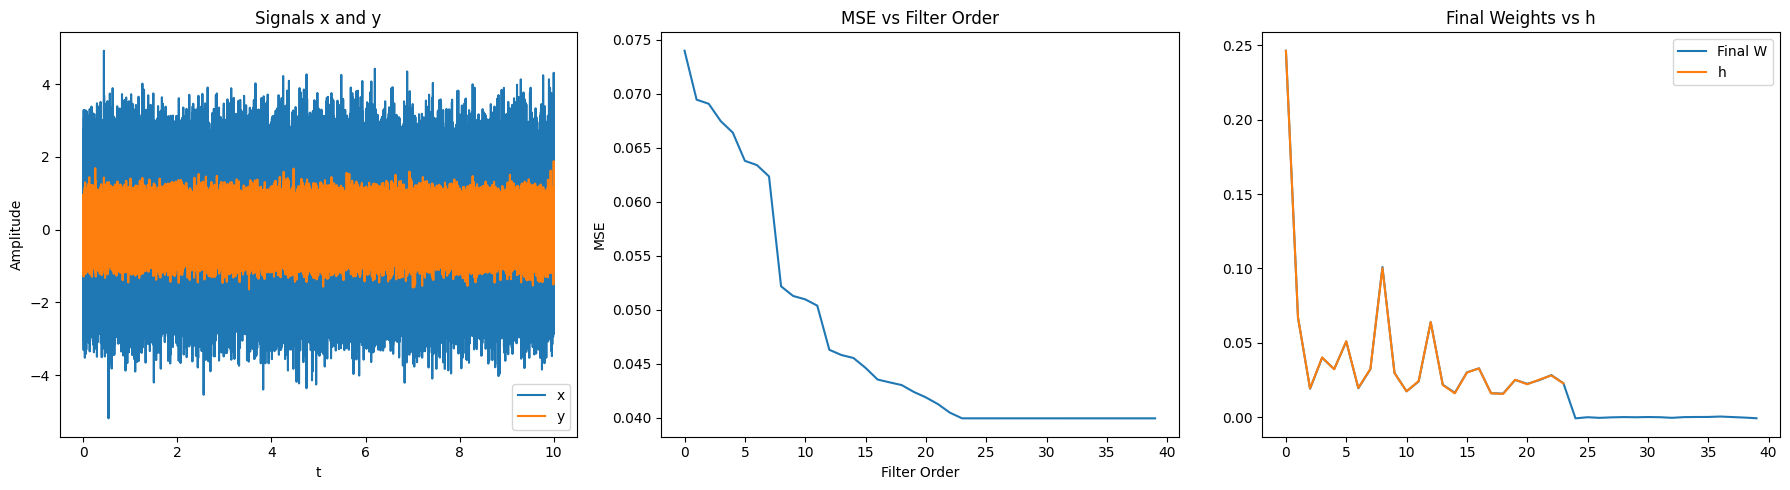

In [16]:
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt

time = 10
fs = 48000

t = np.linspace(0, time, int(time * fs))
x = np.random.normal(0, 1, len(t))

# Dummy filter
order = 24
h = np.ones(order) / np.random.uniform(1, order, order)
h = h / np.sum(h)
y = sp.lfilter(h, 1, x) + np.random.normal(0, 0.2, len(t))

num_runs = 40
results = np.zeros(num_runs)
final_w = []
for i in range(num_runs):
    wo, Jo = CalculateOptimumFilter(x, y, i)
    results[i] = Jo
    if i == num_runs - 1:
        final_w = wo

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(t, x, label="x")
axs[0].plot(t, y, label="y")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Amplitude")
axs[0].legend()
axs[0].set_title("Signals x and y")

axs[1].plot(results)
axs[1].set_xlabel("Filter Order")
axs[1].set_ylabel("MSE")
axs[1].set_title("MSE vs Filter Order")

axs[2].plot(final_w, label="Final W")
axs[2].plot(h, label="h")
axs[2].set_title("Final Weights vs h")
axs[2].legend()

plt.tight_layout()
plt.show()
